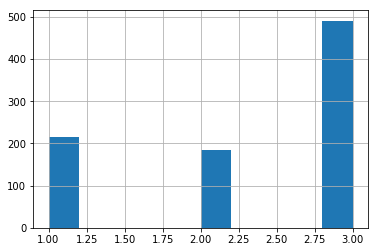

In [54]:
import pandas as pd
import pylab as P
df = pd.read_csv('data/titanic/train.csv', header=0)
df['Pclass'].hist()
P.show()

In [55]:
df['Gender'] = df['Sex'].map({'female':0, 'male':1}).astype(int)
#df = df.dropna()
train_data = df.values
train_data.shape

(891, 13)

In [56]:
train_df = pd.read_csv('data/titanic/train.csv', header=0)
test_df = pd.read_csv('data/titanic/test.csv', header=0)
full_df = train_df.append(test_df, ignore_index = True)
print(full_df.shape)

(1309, 12)


In [57]:
#sex = pd.Series( np.where( full_df.Sex == 'male' , 1 , 0 ) , name = 'Sex' )
#full_df.head()
#embarked = pd.get_dummies(full_df.Embarked, prefix = 'Embarked')
#embarked.head()
#pClass = pd.get_dummies(full_df.Pclass, prefix = 'Pclass')
#pClass.head()

In [58]:
from tensorflow.python.framework import ops
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

In [59]:
#below code copy from https://www.kaggle.com/jeffd23/scikit-learn-ml-from-start-to-finish
#just to familier data transform
def simplify_ages(df):
    df.Age = df.Age.fillna(-0.5)
    bins = (-1, 0, 5, 12, 18, 25, 35, 60, 120)
    group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
    categories = pd.cut(df.Age, bins, labels=group_names)
    df.Age = categories
    return df

def simplify_cabins(df):
    df.Cabin = df.Cabin.fillna('N')
    df.Cabin = df.Cabin.apply(lambda x: x[0])
    return df

def simplify_fares(df):
    df.Fare = df.Fare.fillna(-0.5)
    bins = (-1, 0, 8, 15, 31, 1000)
    group_names = ['Unknown', '1_quartile', '2_quartile', '3_quartile', '4_quartile']
    categories = pd.cut(df.Fare, bins, labels=group_names)
    df.Fare = categories
    return df

def format_name(df):
    df['Lname'] = df.Name.apply(lambda x: x.split(' ')[0])
    df['NamePrefix'] = df.Name.apply(lambda x: x.split(' ')[1])
    return df    
    
def drop_features(df):
    return df.drop(['Ticket', 'Name', 'Embarked'], axis=1)

def transform_features(df):
    df = simplify_ages(df)
    df = simplify_cabins(df)
    df = simplify_fares(df)
    df = format_name(df)
    df = drop_features(df)
    return df

data_train = transform_features(train_df)
data_test = transform_features(test_df)
data_train.head()


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,1,0,3,male,Student,1,0,1_quartile,N,"Braund,",Mr.
1,2,1,1,female,Adult,1,0,4_quartile,C,"Cumings,",Mrs.
2,3,1,3,female,Young Adult,0,0,1_quartile,N,"Heikkinen,",Miss.
3,4,1,1,female,Young Adult,1,0,4_quartile,C,"Futrelle,",Mrs.
4,5,0,3,male,Young Adult,0,0,2_quartile,N,"Allen,",Mr.


In [60]:
from sklearn import preprocessing
def encode_features(df_train, df_test):
    features = ['Fare', 'Cabin', 'Age', 'Sex', 'Lname', 'NamePrefix']
    df_combined = pd.concat([df_train[features], df_test[features]])
    
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df_combined[feature])
        df_train[feature] = le.transform(df_train[feature])
        df_test[feature] = le.transform(df_test[feature])
    return df_train, df_test
    
data_train, data_test = encode_features(data_train, data_test)
data_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,1,0,3,1,4,1,0,0,7,100,19
1,2,1,1,0,0,1,0,3,2,182,20
2,3,1,3,0,7,0,0,0,7,329,16
3,4,1,1,0,7,1,0,3,2,267,20
4,5,0,3,1,7,0,0,1,7,15,19


In [98]:
from sklearn.model_selection import train_test_split

X_all = data_train.drop(['Survived', 'PassengerId'], axis=1)
y_all = data_train['Survived']

num_test = 0.20
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=num_test, random_state=23)
print("X Train:" + str(X_train.shape))
print("Y Train:" + str(y_train.shape))

X_pd_train = X_train.T
y_pd_train = y_train.values.reshape(y_train.shape[0], 1)
#y_train = y_train.T

X_pd_test = X_test.T
y_pd_test = y_test.values.reshape(y_test.shape[0], 1)
#y_test = y_test.T
print("X_train : ", X_pd_train.shape)
print("Y train : ", y_pd_train.shape)
print("X_test : ", X_pd_test.shape)
print("Y test : ", y_pd_test.shape)

#yy = tf.one_hot(y_train, depth=2)
y_train1 = np.eye(2)[y_train.values.reshape(y_train.shape[0])]

y_train = y_train1.T

y_test1 = np.eye(2)[y_test.values.reshape(y_test.shape[0])]

y_test = y_test1.T

print("y_train: ", y_train.shape)
print("y_test: ", y_test.shape)

X Train:(712, 9)
Y Train:(712,)
X_train :  (9, 712)
Y train :  (712, 1)
X_test :  (9, 179)
Y test :  (179, 1)
y_train:  (2, 712)
y_test:  (2, 179)


In [99]:
def create_placeholders(n_x, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_x -- scalar, size of an image vector (num_px * num_px = 64 * 64 * 3 = 12288)
    n_y -- scalar, number of classes (from 0 to 5, so -> 6)
    
    Returns:
    X -- placeholder for the data input, of shape [n_x, None] and dtype "float"
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "float"
    
    Tips:
    - You will use None because it let's us be flexible on the number of examples you will for the placeholders.
      In fact, the number of examples during test/train is different.
    """

    ### START CODE HERE ### (approx. 2 lines)
    X = tf.placeholder(tf.float32, shape = (n_x, None))
    Y = tf.placeholder(tf.float32, shape = (n_y, None))
    ### END CODE HERE ###
    
    return X, Y

In [100]:
def initialize_parameters():
    """
    Initializes parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [25, 9]
                        b1 : [25, 1]
                        W2 : [12, 25]
                        b2 : [12, 1]
                        W3 : [1, 12]
                        b3 : [1, 1]
    W.shape(n(l), n_x)
    
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    """
    
    tf.set_random_seed(1)                   # so that your "random" numbers match ours
        
    ### START CODE HERE ### (approx. 6 lines of code)
    W1 = tf.get_variable("W1", [25,9], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b1 = tf.get_variable("b1", [25,1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable("W2", [12, 25], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b2 = tf.get_variable("b2", [12, 1], initializer = tf.zeros_initializer())
    W3 = tf.get_variable("W3", [2, 12], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b3 = tf.get_variable("b3", [2, 1], initializer = tf.zeros_initializer())
    ### END CODE HERE ###

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [101]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    ### START CODE HERE ### (approx. 5 lines)              # Numpy Equivalents:
    Z1 = tf.add(tf.matmul(W1, X), b1)                                              # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                              # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)                                              # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)                                              # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)                                              # Z3 = np.dot(W3,Z2) + b3
    ### END CODE HERE ###
    
    return Z3

In [102]:
def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    
    ### START CODE HERE ### (1 line of code)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = labels))
    ### END CODE HERE ###
    
    return cost

In [103]:

def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 1500, minibatch_size = 32, print_cost = True):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set, of shape (input size = 12288, number of training examples = 1080)
    Y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    X_test -- training set, of shape (input size = 12288, number of training examples = 120)
    Y_test -- test set, of shape (output size = 6, number of test examples = 120)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of shape (n_x, n_y)
    ### START CODE HERE ### (1 line)
    X, Y = create_placeholders(n_x, n_y)
    ### END CODE HERE ###

    # Initialize parameters
    ### START CODE HERE ### (1 line)
    parameters = initialize_parameters()
    ### END CODE HERE ###
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    ### START CODE HERE ### (1 line)
    Z3 = forward_propagation(X, parameters)
    ### END CODE HERE ###
    
    # Cost function: Add cost function to tensorflow graph
    ### START CODE HERE ### (1 line)
    cost = compute_cost(Z3, Y)
    ### END CODE HERE ###
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    ### START CODE HERE ### (1 line)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    ### END CODE HERE ###
    
    # Initialize all the variables
    init = tf.global_variables_initializer()
    print("Start train")
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = (X_train, y_train)
            #minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            '''for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                ### START CODE HERE ### (1 line)
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                ### END CODE HERE ###
                
                epoch_cost += minibatch_cost / num_minibatches'''
            _ , epoch_cost = sess.run([optimizer, cost], feed_dict={X: X_train, Y: y_train})
            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters

In [104]:
X_train = X_pd_train.values
X_test = X_pd_test.values
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
#print(X_train)
#print(y_train)

(9, 712)
(2, 712)
(9, 179)
(2, 179)


(9, 712)
Start train
Cost after epoch 0: 78.364479
Cost after epoch 100: 44.086620
Cost after epoch 200: 12.262057
Cost after epoch 300: 0.864209
Cost after epoch 400: 0.829837
Cost after epoch 500: 0.805664
Cost after epoch 600: 0.788942
Cost after epoch 700: 0.728213
Cost after epoch 800: 0.707155
Cost after epoch 900: 0.694962
Cost after epoch 1000: 0.686130
Cost after epoch 1100: 0.677820
Cost after epoch 1200: 0.670489
Cost after epoch 1300: 0.664210
Cost after epoch 1400: 0.658675


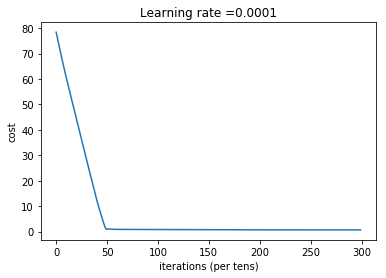

Parameters have been trained!
Train Accuracy: 0.643258
Test Accuracy: 0.681564


In [105]:
print(X_train.shape)
parameters = model(X_train, y_train, X_test, y_test)

In [ ]:
import scipy
from PIL import Image
from scipy import ndimage

## START CODE HERE ## (PUT YOUR IMAGE NAME) 
my_image = "thumbs_up.jpg"
## END CODE HERE ##

# We preprocess your image to fit your algorithm.
fname = "images/" + my_image
image = np.array(ndimage.imread(fname, flatten=False))
my_image = scipy.misc.imresize(image, size=(64,64)).reshape((1, 64*64*3)).T
my_image_prediction = predict(my_image, parameters)

plt.imshow(image)
print("Your algorithm predicts: y = " + str(np.squeeze(my_image_prediction)))

In [19]:

"""
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_x -- scalar, size of an image vector (num_px * num_px = 64 * 64 * 3 = 12288)
    n_y -- scalar, number of classes (from 0 to 5, so -> 6)
    
    Returns:
    X -- placeholder for the data input, of shape [n_x, None] and dtype "float"
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "float"
    
    Tips:
    - You will use None because it let's us be flexible on the number of examples you will for the placeholders.
      In fact, the number of examples during test/train is different.
    """
X = tf.placeholder(tf.float32, shape = (X_train.shape[0], None))
Y = tf.placeholder(tf.float32, shape = (1, None))
print("X = " + str(X))
print("Y = " + str(Y))

#b1 = tf.get_variable("b1", [1], initializer = tf.zeros_initializer())
#W1 = tf.get_variable("W1", [791,1], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
'''
shape of W1 is (output size, input feature size)
'''
b1 = tf.Variable(tf.zeros([1]))
W1 = tf.Variable(tf.random_uniform([1,9]))
y = tf.matmul(W1, X) + b1

parameters = {"W1": W1,
                  "b1": b1}

print("y = " + str(y))

X = Tensor("Placeholder:0", shape=(9, ?), dtype=float32)
Y = Tensor("Placeholder_1:0", shape=(1, ?), dtype=float32)
y = Tensor("add:0", shape=(1, ?), dtype=float32)


In [20]:
loss = tf.reduce_mean(tf.square(y - y_train))
optimiser = tf.train.GradientDescentOptimizer(0.5)
train = optimiser.minimize(loss)

In [21]:

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    for step in range(0, 100):
        _, batch_cost = sess.run([train, loss], feed_dict={X: X_train, Y: y_train})
        if(step % 20 == 0):
            print("Cost:", batch_cost)
            #print(step, sess.run(W), sess.run(b))

Cost: 32256.4
Cost: nan
Cost: nan
Cost: nan
Cost: nan


In [22]:
predictions = clf.predict(X_test)
print(accuracy_score(y_test, predictions))

NameError: name 'clf' is not defined

In [23]:
ids = data_test['PassengerId']
predictions = clf.predict(data_test.drop('PassengerId', axis=1))


output = pd.DataFrame({ 'PassengerId' : ids, 'Survived': predictions })
# output.to_csv('titanic-predictions.csv', index = False)
output.head()

NameError: name 'clf' is not defined